In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal, norm

### The Big Problem

In *B - Location optimisation with Gaussian Processes* I looked at how you can choose a good location while minimizing the number of samples that you take. The solution was to use a Gaussian process and maximize the expected improvement at each sample. Now we turn to a related problem. In the real world, robots are not limited by the number of samples, but rather by the size of their batteries. Taking samples and moving both incur costs. Given a fixed energy budget, how do you determine where to sample?

If each robot $i$ travels some path $P_i$, sampling at each location, we want to choose these paths to maximize the final sample obtained, subject to an energy budget:
$$
\max_{P_1,\dots,P_n} F(\text{observations along } \cup_i P_i)
\quad \text{subject to} \quad C(P_i) \le B \;\; \forall i,
$$
where $B$ is the available budget and $F(\cdot)$ is the function.

This relates to the well-known Multi-robot Informative Path Planning (MIPP) problem, where you want to choose a math which maximizes the information gained. This is a good starting point, as mutual information has some nice properties (diminishing returns, always increasing with each sample, normalized) which make it suitable for greedy algorithms. We can start by thinking about how to maximize information gained and then think about how to maximize any function at the robot's final location.

### A brief detour into information theory

'Information'. What is it? Well, imagine I am looking out the window. You are sitting in the house. I notice two things. First, that it's sunny. Secondly, that a squirrel is running up the tree in the front yard. Both of these statements contain information. But notice that the second one takes many more words to say. That's because it is more specific. A squirrel running up a tree is one of many different things that could be happening in the front yard. The weather is only going to be one of a few things. You can think of information as the number of words or the amount of communication I need to tell you what the sample is from a distribution. The distribution of weather has a smaller range, so I need fewer words to describe it. 

Take the example of flipping a coin. Say I flip it 2 times and I need to tell you what the results were. How many words do I need? Well, it's exactly 2. 2 is the information content I have after observing the coin flipped twice. But now consider a skewed distribution. Say that I get heads 90% of the time. Then getting heads twice is very common and I should probably use fewer words to tell you that the usual thing has happened. Imagine I say "Usual" if I get heads twice, and otherwise I say "Unusual" followed by the results if I don't. How many words do I use now? Well, instead of 2 words every time, the expected number is $0.81 + 0.19 \times 3 = 1.38$, much lower! The reason is that with the *shared* knowledge of the distribution and its skew I have a lower amount of information to communicate to you. Information reflects the surprise upon seeing a particular result.

Now we want to formalize this. One property we would like is that information should add for independent events. That is, if I learn the outcome of two independent events, the total information gained should be the sum of the information gained from each one separately. For independent events, probabilities multiply. So we are looking for a function that converts products of probabilities into sums of numbers. The only function with this property (up to a scaling factor) is the logarithm.

This motivates defining the information content of an event with probability $p$ as
$$
\log \frac{1}{p} = -\log p.
$$

In simpler terms the number of words I need to describe something happening grows logarithmically with how unlikely it is. 

Next we can look at entropy, which is just the expected information for some set of discrete events $X$:
$$
H(X) = -\sum_{x\in X} p(x) \log p(x)
$$

And we get mutual information, which is the reduction in uncertainty about one variable after observing another:
$$
I(X;Y) = H(X) - H(X|Y)
$$

Here $X$ could be your test data and $Y$ your known data. In the location optimization context, $Y$ is where you choose to explore and $X$ is what remains unknown.

### Back to the problem

In the MIPP framework we are minimizing the mutual information between the points we don't visit before knowing samples and the points we don't visit after knowing samples. Specifically if have a set of $V$ points and we sample $A$ then the mutual information is:

$$MI(A) = H(V\notin A) - H(V\notin A | A)$$

Where $H$ is the entropy.

If we model out problem with a Gaussian Process (GP) then we can easily measure the mutual information. We have the normal distribution for each unknown point before and after inference. The entropy of a gaussian is $\frac{1}{2}\log\!\big( (2\pi e)^d \, |\Sigma| \big)$.

Let's see an example.

In [2]:
def rbf_kernel(Xa, Xb, lengthscale=0.1):
    sqdist = (
        np.sum(Xa**2, axis=1)[:, None]
        + np.sum(Xb**2, axis=1)[None, :]
        - 2 * Xa @ Xb.T
    )
    return np.exp(-sqdist / (2 * lengthscale**2))

def condition_gaussian(mean, cov, known_indicies, known_values):
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    known_indicies = np.asarray(known_indicies)
    known_values = np.asarray(known_values)

    all_indicies = np.arange(len(mean))
    unknown_indicies = np.setdiff1d(all_indicies, known_indicies)

    mu_k = mean[known_indicies]
    mu_u = mean[unknown_indicies]

    Sigma_kk = cov[np.ix_(known_indicies, known_indicies)]
    Sigma_ku = cov[np.ix_(known_indicies, unknown_indicies)]
    Sigma_uk = cov[np.ix_(unknown_indicies, known_indicies)]
    Sigma_uu = cov[np.ix_(unknown_indicies, unknown_indicies)]

    Sigma_kk_inv = np.linalg.inv(Sigma_kk)

    cond_mean = mu_u + Sigma_uk @ Sigma_kk_inv @ (known_values - mu_k)
    cond_cov = Sigma_uu - Sigma_uk @ Sigma_kk_inv @ Sigma_ku

    return cond_mean, cond_cov

def plot_gp_surface(X, Y_true, mean_post, cov_post, visited_points, n, figsize=(12,6)):
    N = n * n
    all_idx = np.arange(N)
    unvisited = np.setdiff1d(all_idx, visited_points)

    # Reconstruct full mean/std
    mean_full = np.zeros(N)
    std_full = np.zeros(N)
    mean_full[visited_points] = Y_true[visited_points]
    std_full[visited_points] = 0.0
    mean_full[unvisited] = mean_post
    std_full[unvisited] = np.sqrt(np.diag(cov_post))

    # Reshape grids
    X1 = X[:,0].reshape(n,n)
    X2 = X[:,1].reshape(n,n)
    Y_surf = Y_true.reshape(n,n)
    mean_surf = mean_full.reshape(n,n)
    std_surf = std_full.reshape(n,n)
    z_upper = mean_surf + std_surf
    z_lower = mean_surf - std_surf

    # Define a flat plane below the surfaces for scatter points
    z_base = np.min(Y_true) - 0.2*(np.max(Y_true)-np.min(Y_true))  # a bit below min value

    # Create plots
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Left: True function
    ax1.plot_surface(X1, X2, Y_surf, color='black', alpha=0.9, linewidth=0)
    # draw vertical stems from z_base up to points
    for idx in visited_points:
        ax1.plot([X[idx,0], X[idx,0]], [X[idx,1], X[idx,1]], [z_base, Y_true[idx]], color='red', lw=2)
        ax1.scatter(X[idx,0], X[idx,1], z_base, color='red', s=50)
    ax1.set_title("True function")
    ax1.set_xlabel("x1"); ax1.set_ylabel("x2"); ax1.set_zlabel("y")

    # Right: GP posterior with uncertainty
    ax2.plot_surface(X1, X2, z_lower, color='grey', alpha=0.5, linewidth=0)
    ax2.plot_surface(X1, X2, mean_surf, color='blue', alpha=0.8, linewidth=0)
    ax2.plot_surface(X1, X2, z_upper, color='grey', alpha=0.5, linewidth=0)
    # draw vertical stems from z_base up to points
    for idx in visited_points:
        ax2.plot([X[idx,0], X[idx,0]], [X[idx,1], X[idx,1]], [z_base, Y_true[idx]], color='red', lw=2)
        ax2.scatter(X[idx,0], X[idx,1], z_base, color='red', s=50)
    ax2.set_title("GP posterior ± std")
    ax2.set_xlabel("x1"); ax2.set_ylabel("x2"); ax2.set_zlabel("y")

    plt.tight_layout()
    plt.show()

def get_MI(visited_points, cov, cov_post):
    unvisited = np.setdiff1d(np.arange(cov.shape[0]), visited_points)
    cov_unvisited = cov[np.ix_(unvisited, unvisited)]
    d = cov_unvisited.shape[0]
    sign_prior, logdet_prior = np.linalg.slogdet(cov_unvisited)
    sign_post, logdet_post = np.linalg.slogdet(cov_post)
    entropy_prior = 0.5 * (d * np.log(2*np.pi*np.e) + logdet_prior)
    entropy_post  = 0.5 * (d * np.log(2*np.pi*np.e) + logdet_post)    
    MI = entropy_prior - entropy_post
    return MI

In [3]:
n = 50
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack([X1.ravel(), X2.ravel()])
cov = rbf_kernel(X, X, lengthscale=0.5) + 1e-8 * np.eye(len(X))
mean = np.zeros(n * n)
Y = np.random.multivariate_normal(mean, cov)

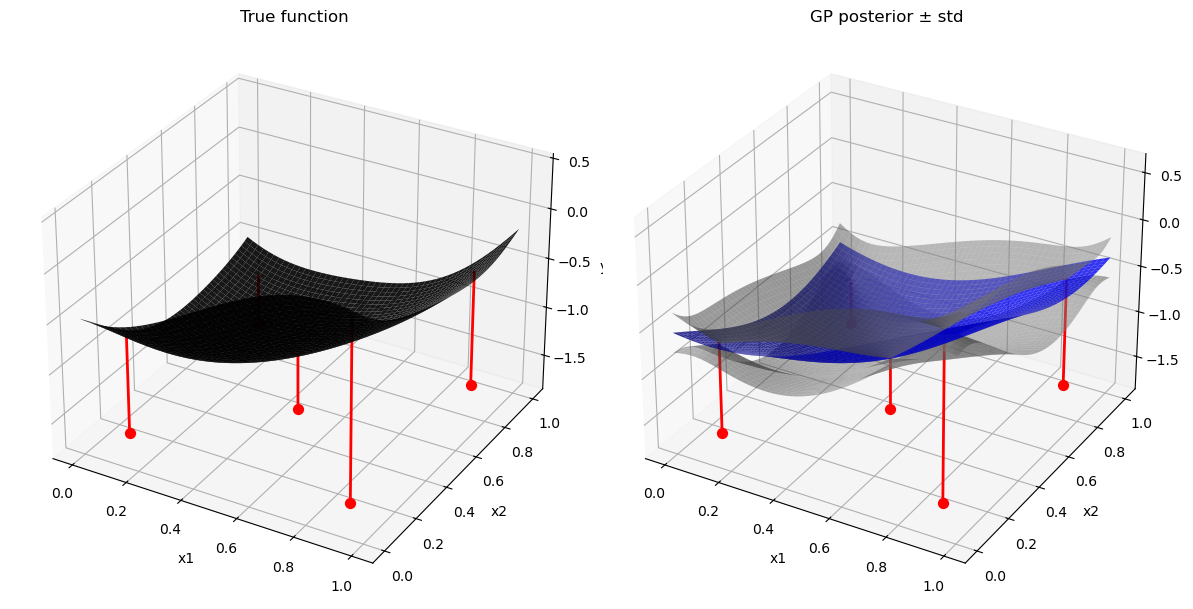

MI: 45.24929368152152


In [4]:
# Getting MI with 5 spread points:
visited_coords = np.array([[0.1,0.1],[0.1,0.9],[0.5,0.5],[0.9,0.1],[0.9,0.9]])
visited_points = [np.argmin(np.linalg.norm(X - c, axis=1)) for c in visited_coords]
mean_post, cov_post = condition_gaussian(mean, cov, visited_points, Y[visited_points])
plot_gp_surface(X, Y, mean_post, cov_post, visited_points, n)
print("MI:",get_MI(visited_points, cov, cov_post))

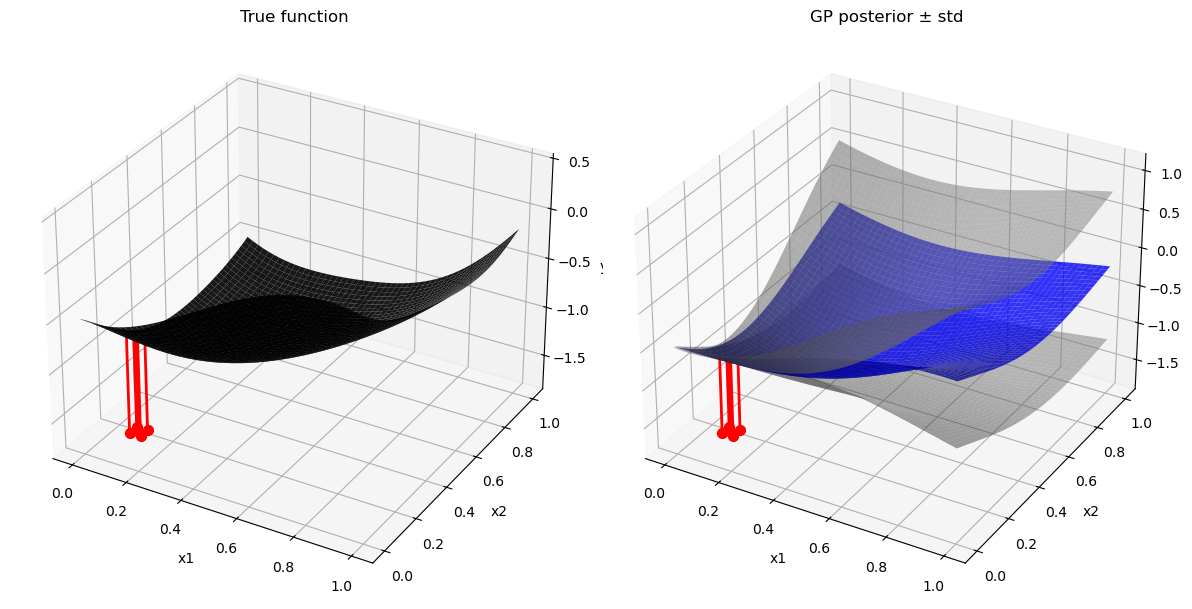

MI: 29.56089666462867


In [5]:
# Choosing 5 close together points
visited_coords = np.array([[0.1,0.1],[0.1,0.14],[0.12,0.12],[0.14,0.1],[0.14,0.14]])
visited_points = [np.argmin(np.linalg.norm(X - c, axis=1)) for c in visited_coords]
mean_post, cov_post = condition_gaussian(mean, cov, visited_points, Y[visited_points])
plot_gp_surface(X, Y, mean_post, cov_post, visited_points, n)
print("MI:",get_MI(visited_points, cov, cov_post))

Nice. When we spread points out we get a higher MI, as the entropy has been reduced more.

So, given an energy budget, how do you choose where to move? Obviously the choice depends on the cost of sampling, the cost of moving, and the value of the function. The problem is that the value depends on what samples you have already taken and what samples you will take in the future. Fortunately, the mutual information *doesn't depend on the actual values*, so it can be computed for any combination of points beforehand. The formula for conditioning a gaussian is:

$$
\mu_{1|2} = \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(a - \mu_2)
$$

$$
\Sigma_{1|2} = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
$$

And the entropy is just defined:

$$ \frac{1}{2}\log\!\big( (2\pi e)^d \, |\Sigma| \big) $$

Where $d$ is the number of dimensions.

Using the formula for mutual information we get:

$$\frac{1}{2}\log\!\big( (2\pi e)^d \, |\Sigma_{11}| \big) - \frac{1}{2}\log\!\big( (2\pi e)^d \, |\Sigma_{1|2}| \big)$$

$$= \frac{1}{2}\log\!\big( (2\pi e)^d \, |\Sigma_{11}| \big) - \frac{1}{2}\log\!\big( (2\pi e)^d \, |\Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}| \big)$$

$$= \frac{1}{2}d\log (2\pi e) + \frac{1}{2}\log|\Sigma_{11}| - \frac{1}{2}d\log (2\pi e) -\frac{1}{2}\log|\Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}|$$

Cancelling out...

$$= \frac{1}{2}\log|\Sigma_{11}| -\frac{1}{2}\log|\Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}|$$

And using something called the 'Schur complement' blah blah blah we get:

$$=\frac{1}{2}\log\frac{|\Sigma_{11}||\Sigma_{22}|}{|\Sigma|}$$

So we can calculate the mutual information without actually observing anything. Unfortunately it's still expensive in the number of options! And we also aren't actually optimizing the function, we're maximizing the mutual information. So can we do better? In the original paper above they use a grid and then branch and bound techniques on it using the submodularity benefits of mutual information. 

### A solution?

I'm wondering if there is an option to keep the idea of expected improvement, but introduce some energy discounting. I.e., discount expected improvement by the amount of energy it takes to get there. Noting, though, that any sample taken would probably need to leave you at least enough budget to return to the best point so far.

Given an energy budget and discounting curve we can see how agents perform on a test problem:

In [6]:
def expected_improvement(mean, std, best, min_std=1e-2):
    std = np.maximum(std, min_std)  # floors std so it never goes below min_std
    Z = (mean - best) / std
    return (mean - best) * norm.cdf(Z) + std * norm.pdf(Z)


def distance_discounting(d, phi):
    return np.exp(-phi*d**2)

def run_GP_optimizer(x, y, starting_budget, distance_cost, sampling_cost, phi, start_point, plots=False):
    if plots:
        d = np.linspace(0,1,100)
        plt.figure(figsize=(5,2))
        plt.plot(d,distance_discounting(d,phi))
        plt.ylim(0,1)
        plt.title("Distance discounting")
        plt.show()

    mean = np.zeros(len(x))
    cov = rbf_kernel(x.reshape(-1,1), x.reshape(-1,1)) + 1e-8 * np.eye(len(x))
    std = np.sqrt(np.diag(cov))

    peak_value, peak_point, budget, current_value, current_point = -100, start_point, starting_budget, -100, start_point
    x_copy, y_copy = x.copy(), y.copy()
    x_samples, y_samples = [], []

    def plot_gp(title):
        plt.figure(figsize=(10,2))
        plt.plot(x, y, label="True")
        plt.scatter(x_samples, y_samples, color="red", label="Samples")
        plt.fill_between(x_copy, mean[:len(x_copy)]-std[:len(x_copy)], mean[:len(x_copy)]+std[:len(x_copy)],
                         color="gray", alpha=0.3, label="GP uncertainty")
        plt.plot(x_copy, mean[:len(x_copy)], 'k-', label="GP mean")
        reach = budget / distance_cost
        plt.axvspan(max(x.min(), current_point-reach), min(x.max(), current_point+reach), color="blue", alpha=0.1)
        plt.scatter(current_point, current_value, s=150,
                    color="lime" if "Final" in title else "green", edgecolor="black", zorder=10)
        plt.title(title + f" | Budget: {budget:.2f}")
        
        y_min, y_max = y.min(), y.max()
        y_padding = 0.05 * (y_max - y_min)
        plt.ylim(y_min - y_padding, y_max + y_padding)
        
        plt.show()

    while True:
        ei = expected_improvement(mean, std, peak_value)
        distances = np.abs(x_copy - current_point)
        remaining_budget = budget - distances * distance_cost - sampling_cost
        scores = ei * distance_discounting(distances, phi) * (np.abs(x_copy - peak_point)*distance_cost < remaining_budget)
        if not scores.any(): break

        idx = np.argmax(scores)
        next_point, observed_y = x_copy[idx], y_copy[idx]

        mean, cov = condition_gaussian(mean, cov, [idx], observed_y)
        std = np.sqrt(np.diag(cov))

        if observed_y > peak_value:
            peak_value, peak_point = observed_y, next_point

        budget -= np.abs(next_point - current_point) * distance_cost + sampling_cost
        current_point = next_point
        current_value = observed_y

        x_samples.append(current_point)
        y_samples.append(observed_y)

        x_copy = np.delete(x_copy, idx)
        y_copy = np.delete(y_copy, idx)

        if plots: plot_gp(f"Step at {current_point:.2f}")

    # Final move back to peak
    if current_point != peak_point:
        distance_to_peak = np.abs(peak_point - current_point)
        if distance_to_peak * distance_cost <= budget:
            budget -= distance_to_peak * distance_cost
        current_point = peak_point
        current_value = peak_value
        if plots: plot_gp("Final")

    return current_point

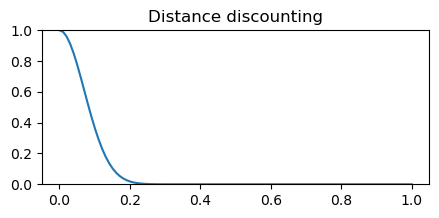

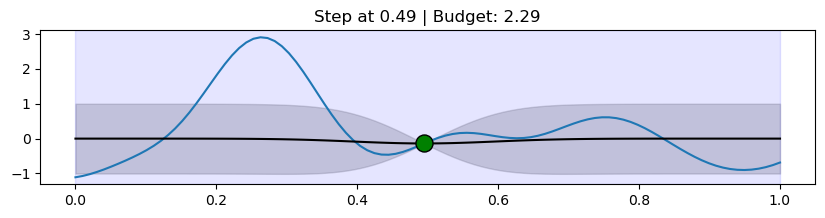

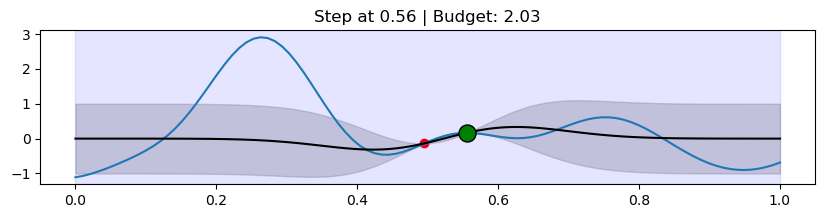

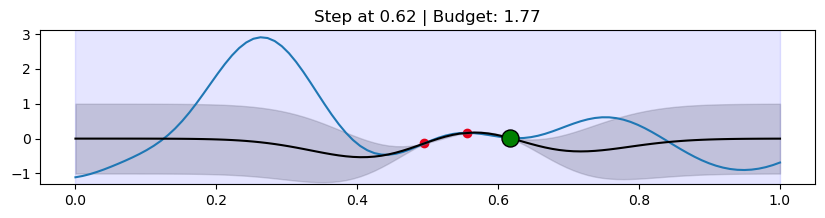

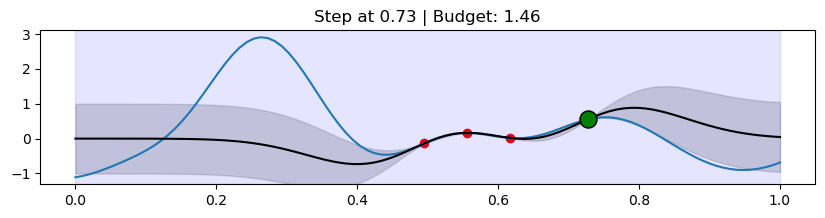

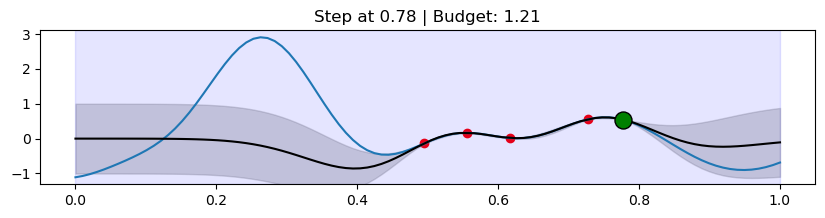

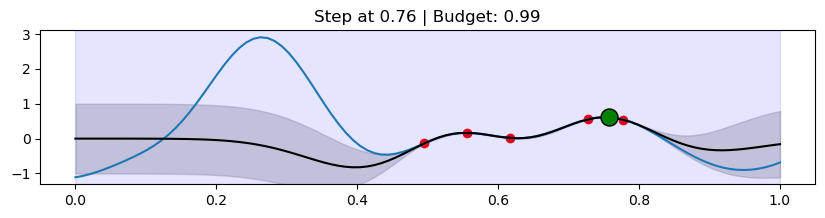

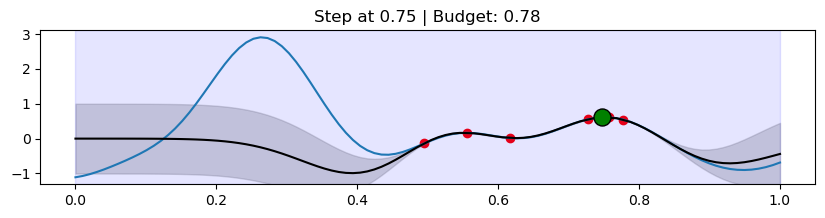

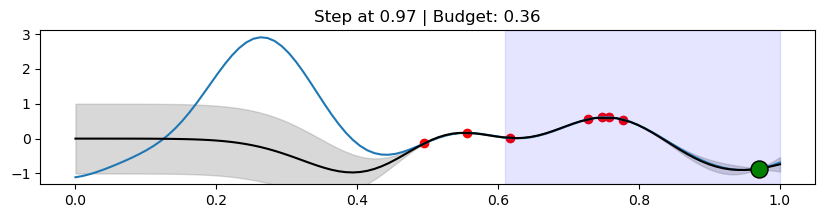

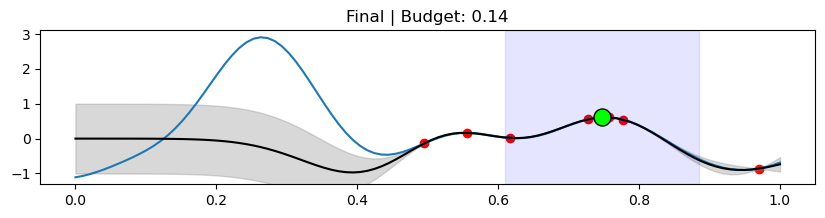

In [7]:
budget = 2.5
distance_cost = 1
sampling_cost = 0.2
phi = 100
start_point = 0.5
x = np.linspace(0,1,100)
cov = rbf_kernel(x.reshape(-1,1), x.reshape(-1,1)) + 1e-8 * np.eye(len(x))
y = np.random.multivariate_normal(np.zeros(len(x)), cov)
end = run_GP_optimizer(x, y, budget, distance_cost, sampling_cost, phi, start_point, plots=True)

Great! Notice that it takes baby steps and doesn't go too far out. 

We can now try to find a good parameter for $\phi$, the lengthscale we use to discount distances. We can see how well agents do by randomizing curves and starting points. This will take a while...

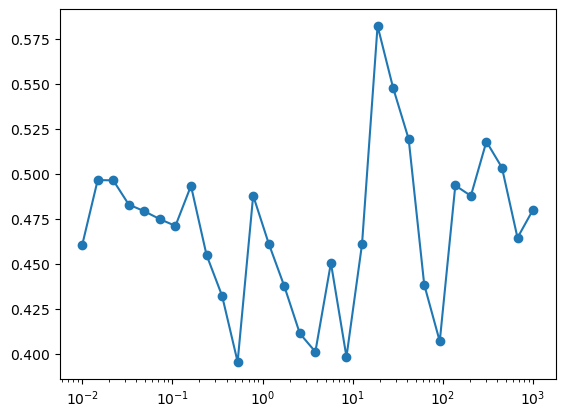

In [8]:
phis = np.logspace(np.log10(1000), np.log10(0.01), 30)
scores = []

for phi in phis:
    run_scores = []
    for j in range(1000):
        budget = 2.5
        distance_cost = 1
        sampling_cost = 0.2
        start_point = 0.5
    
        cov = rbf_kernel(x.reshape(-1,1), x.reshape(-1,1)) + 1e-8 * np.eye(len(x))
        y = np.random.multivariate_normal(np.zeros(len(x)), cov)
        score = run_GP_optimizer(x, y, budget, distance_cost, sampling_cost, phi, start_point)
        run_scores.append(score)
    
    avg_score = np.mean(run_scores)
    scores.append(avg_score)

plt.plot(phis, scores, marker='o')
plt.xscale('log')
plt.show()

You can see a peak around 18, which gives this curve:

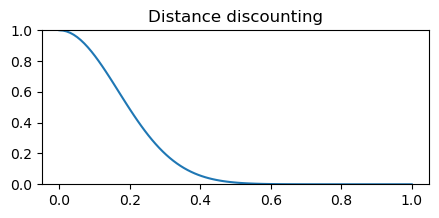

In [10]:
d = np.linspace(0,1,100)
plt.figure(figsize=(5,2))
plt.plot(d,distance_discounting(d,18))
plt.ylim(0,1)
plt.title("Distance discounting")
plt.show()

And notice that there is a significant improvement we get from using this method! Ignoring the energy budget is not an option. Of course, there are bound to be better, more principled, options than the above heuristic. 